#Predictor

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Projects/Collision-Prediction

Mounted at /content/gdrive
/content/gdrive/MyDrive/Projects/Collision-Prediction


In [2]:
#@title Imports
import os
import random
import numpy as np
import imageio.v3 as iio
import matplotlib.pyplot as plt

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler

# Torchvision
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.transforms as T

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


##Load Data

In [3]:
#@title Import Tensor Data
# Train
masks = torch.load('data/masks.pt')
# Validation
val_masks = torch.load('data/val_masks.pt')

# Train
# masks = torch.load('data/SMALL_data/SMALL_masks.pt')
# # Validation
# val_masks = torch.load('data/SMALL_data/SMALL_val_masks.pt')

In [4]:
print(masks.shape)
print(val_masks.shape)

torch.Size([1000, 22, 160, 240])
torch.Size([1000, 22, 160, 240])


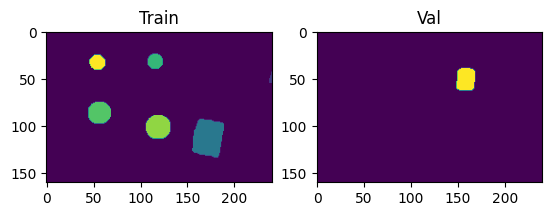

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(6.4, 2.4))
axes[0].imshow(masks[0][0])
axes[1].imshow(val_masks[0][0])
axes[0].set_title("Train")
axes[1].set_title("Val")
plt.show()

In [35]:
#@title Dataset Class & Loaders
class MaskDataset(Dataset):
  def __init__(self, masks, transform=None):
    self.masks = masks.reshape(-1, 22, 160, 240)
    self.t = transforms.RandomHorizontalFlip()
  
  def __len__(self):
    return len(self.masks)

  def __getitem__(self, index):
    msk = self.masks[index]
    msk = self.t(msk) # Random Horizontal Flip: augmentation

    return msk

# Datasets
train_dataset = MaskDataset(masks)
val_dataset = MaskDataset(val_masks)

batch_size = 16

# Data Loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

torch.Size([16, 22, 160, 240])


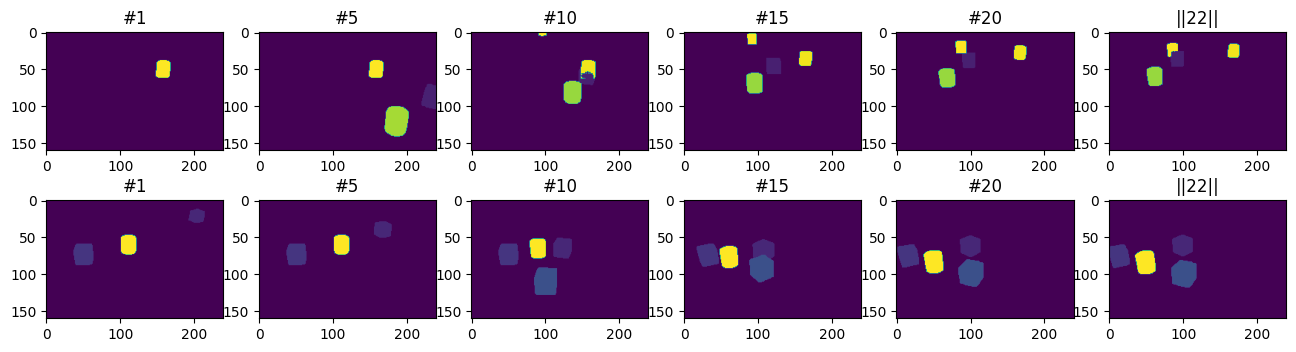

In [36]:
#@title Visualize
example = next(iter(val_loader))
# mask, targ = [x for x in example]
mask = example

print(mask.shape)
# print(targ.shape)

fig, axes = plt.subplots(2, 6, figsize=(16, 4))
for i in range(2):
  axes[i][0].imshow(mask[i][0])
  axes[i][1].imshow(mask[i][4])
  axes[i][2].imshow(mask[i][9])
  axes[i][3].imshow(mask[i][14])
  axes[i][4].imshow(mask[i][19])
  axes[i][0].set_title("#1")
  axes[i][1].set_title("#5")
  axes[i][2].set_title("#10")
  axes[i][3].set_title("#15")
  axes[i][4].set_title("#20")

  # axes[i][5].imshow(targ[i])
  axes[i][5].imshow(mask[i][21])
  axes[i][5].set_title("||22||")
plt.show()

##Model (UNet)

In [37]:
#@title Conv Block
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

In [38]:
#@title Encoder Block
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

In [39]:
#@title Decoder Block
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x

In [40]:
#@title UNet Block
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed_dim = 32
        self.emb = nn.Embedding(49, self.embed_dim)

        """ Encoder """
        self.e1 = encoder_block(11*self.embed_dim, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 49, kernel_size=1, padding=0)

    def forward(self, inputs): # B x S x H x W
        check = True

        for i in range(11): # Embed each image in sequence
          temp = inputs[:, i, :, :]  # B x H x W
          temp = self.emb(temp)  # B x H x W x 32
          temp = temp.permute(0, 3, 1, 2)  # B x 32 x H x W 

          if check:
            x = temp
            check = False
          else:
            x = torch.cat((x, temp), dim=1)

        """ Encoder """
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4).unsqueeze(1)

        return outputs

##Training

In [41]:
#@title Settings

in_channels = 1
embed_dim = 256
num_heads = 16
mlp_dim = 1024
num_layers = 8
latent_dim = 128

batch_size = 64

In [42]:
# model = TAE(in_channels, embed_dim, num_heads, mlp_dim, num_layers, latent_dim).to(device)
model = UNet().to(device)
model.load_state_dict(torch.load("./predictor_models/best_predictor.pth")) # LOAD TRAINED MODEL
input_tensor = train_dataset[0].unsqueeze(0)[:, :11, :, :].to(device).long()
output = model(input_tensor)
print(output.shape)
print(f"Number of Weights: {sum(p.numel() for p in model.parameters()):,}")

result = {"train": [], "val": []} # For tracking loss
best_val = -1 # Negative as real val will be positive

torch.Size([1, 1, 49, 160, 240])
Number of Weights: 31,249,233


In [43]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()

In [44]:
#@title Display Mask Output Comparison
def display_comp(model, index, ds="val"):
  if ds == "val":
    ex = next(iter(val_loader))
    seq = ex[index][:11]
    targ = ex[index][11, :, :]
  elif ds == "train":
    ex = next(iter(train_loader))
    seq = ex[index][:11]
    targ = ex[index][11, :, :]

  pred_mask = model(seq.unsqueeze(0).to(device).long()).cpu().squeeze(0).squeeze(0)

  fig, axes = plt.subplots(1, 2, figsize=(6, 3))
  axes[0].imshow(targ, vmin=0, vmax=48)
  axes[1].imshow(pred_mask.argmax(0), vmin=0, vmax=48)
  plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 1 | Train: 0.0113 | Val: 0.0158


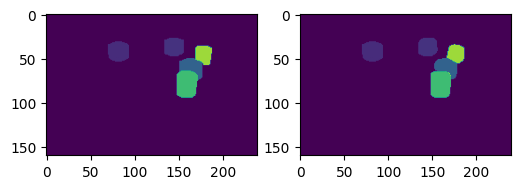

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 2 | Train: 0.0110 | Val: 0.0158


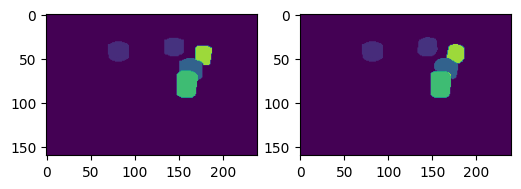

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 3 | Train: 0.0109 | Val: 0.0159


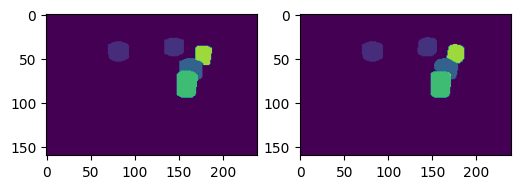

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 4 | Train: 0.0107 | Val: 0.0158


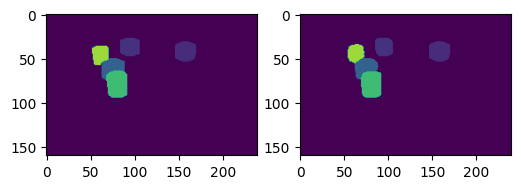

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 5 | Train: 0.0106 | Val: 0.0162


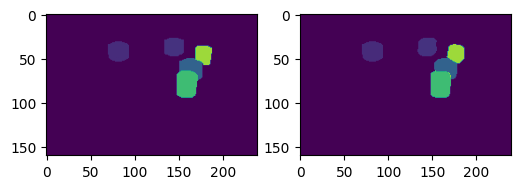

Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 6 | Train: 0.0103 | Val: 0.0158


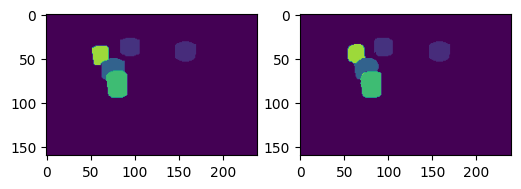

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 7 | Train: 0.0103 | Val: 0.0158


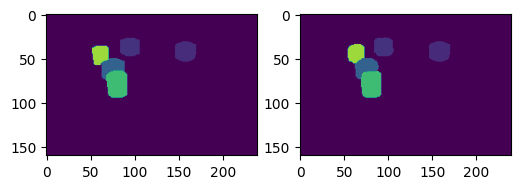

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch 8 | Train: 0.0103 | Val: 0.0160


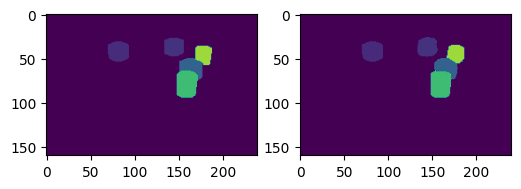

In [45]:
#@title Training
from tqdm.notebook import tqdm

num_epochs = 8

def get_loss(seq, targ, optimizer=None):
  pred_mask = model(seq.long()).squeeze(1)
  loss = criterion(pred_mask, targ.long())

  if optimizer is not None:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return loss

for epoch in tqdm(range(1, num_epochs+1), leave=False): # Train on several epochs
  total_train_loss = 0
  model.train()
  for batch in tqdm(train_loader, leave=False):
    for i in range(10): # Generate next image 10 times | This is where we shift the model inputs
      mask_seq = batch[:, i:11+i, :, :].to(device)
      targ = batch[:, 11+i, :, :].to(device)
      total_train_loss += get_loss(mask_seq, targ, optimizer=optimizer)

  train_loss = total_train_loss.item() / (10*len(train_loader))
  result["train"].append(train_loss)

  # Test model on validation
  with torch.no_grad():
    val_result = 0
    count = 0
    model.eval()
    total_val_loss = 0
    for batch in val_loader:
      for i in range(10): # Generate next image 10 times | This is where we shift the model inputs
        mask_seq_val = batch[:, i:11+i, :, :].to(device)
        targ_val = batch[:, 11+i, :, :].to(device)
        total_val_loss += get_loss(mask_seq_val, targ_val) * mask_seq_val.size(0)
        count += mask_seq_val.size(0)

    val_result = total_val_loss.item() / count
    result["val"].append(val_result)
    print(f"Epoch {epoch} | Train: {train_loss:.4f} | Val: {val_result:.4f}")

    if (best_val == -1) or (val_result < best_val):
        best_val = val_result
        torch.save(model.state_dict(), "./predictor_models/best_predictor.pth")

    display_comp(model, 3)
  scheduler.step(total_val_loss)

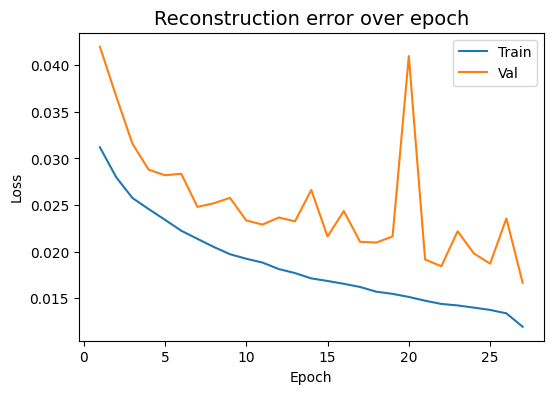

In [41]:
fig_prog = plt.figure(figsize=(6,4))

plt.plot(range(1, len(result["train"])+1), result["train"], label="Train")
plt.plot(range(1, len(result["val"])+1), result["val"], label="Val")
plt.title("Reconstruction error over epoch", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

##Results